# Preparación del dataset para YOLOv4

Se creará la estructura de directorios para Darknet:

~~~
./kaggle-fisheries-yolo/
  |- data/
  |   |- 00000.jpg
  |   |- 00000.txt
  |   |- ...
  |- classes.names
  |- train.txt
  |- test.txt
  |- yolo-fisheries.cfg
  |- fisheries.data
 ~~~

In [1]:
import json
import os
import shutil
import glob
import PIL
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
#from google.colab import drive

In [2]:
#WORKSPACE_PATH = "/home/jovyan/work/" # docker
#WORKSPACE_PATH = "/notebooks/" # otro docker
WORKSPACE_PATH = "../../" # pc-invap
!ls {WORKSPACE_PATH}

ai-for-fisheries.code-workspace  object-detector
assets				 object-detector-trainer
biblio				 planning
build.sh			 prueba.sh
compose				 README.md
data				 reports
data-preparation		 run-jupyter-data-science.sh
dockers				 run-jupyter-local.sh
env.sh				 TestEnvironment.ipynb
minutas.md			 videoanalytics
model-development-and-training


In [3]:
WORKSPACE_DATA_PATH = WORKSPACE_PATH+"/data/"
KAGGLE_FISHERIES_DATASET = WORKSPACE_DATA_PATH+"/datasets/kaggle-fisheries/"
!ls {KAGGLE_FISHERIES_DATASET}

kaggle-ncfm			sample_submission_stg2.csv.zip	test_stg2.7z
__MACOSX			test_stg1			train
sample_submission_stg1.csv.zip	test_stg1.zip			train.zip


In [4]:
# Dataset original
KAGGLE_FISHERIES_TRAIN_IMG=KAGGLE_FISHERIES_DATASET+"/train/"
KAGGLE_FISHERIES_BB=KAGGLE_FISHERIES_DATASET+"/kaggle-ncfm/"

In [5]:
# Dataset YOLO (a generar)
KAGGLE_FISHERIES_DATASET_YOLO = WORKSPACE_DATA_PATH+"/datasets/kaggle-fisheries-yolo/"
KAGGLE_FISHERIES_DATASET_YOLO_IMAGES = KAGGLE_FISHERIES_DATASET_YOLO+"/data/"
KAGGLE_FISHERIES_DATASET_YOLO_LABELS = KAGGLE_FISHERIES_DATASET_YOLO+"/data/"

Imagenes de entrenamiento.

In [6]:
!ls {KAGGLE_FISHERIES_TRAIN_IMG}

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


Bounding boxes.

In [7]:
!ls {KAGGLE_FISHERIES_BB}

alb_labels.json  dol_labels.json  NoF_labels.json    shark_labels.json
bet_labels.json  lag_labels.json  other_labels.json  yft_labels.json


In [8]:
class_labels={
    "alb": {
        "class_idx": 0,
        "bb_filename": KAGGLE_FISHERIES_BB+"alb_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/ALB"
    },
    "bet": {
        "class_idx": 1,
        "bb_filename": KAGGLE_FISHERIES_BB+"bet_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/BET"
    },
    "dol": {
        "class_idx": 2,
        "bb_filename": KAGGLE_FISHERIES_BB+"dol_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/DOL"
    },
    "lag": {
        "class_idx": 3,
        "bb_filename": KAGGLE_FISHERIES_BB+"lag_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/LAG"
    },
    "shark": {
        "class_idx": 4,
        "bb_filename": KAGGLE_FISHERIES_BB+"shark_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/SHARK"
    },
    "yft": {
        "class_idx": 5,
        "bb_filename": KAGGLE_FISHERIES_BB+"yft_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/YFT"
    },
    "other": {
        "class_idx": 6,
        "bb_filename": KAGGLE_FISHERIES_BB+"other_labels.json",
        "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/OTHER"
    },
    
    #"nof": {
    #        "class_idx": 7,
    #    "bb_filename": KAGGLE_FISHERIES_BB+"other_labels.json",
    #    "train_img": KAGGLE_FISHERIES_TRAIN_IMG+"/NoF"
    #}
}

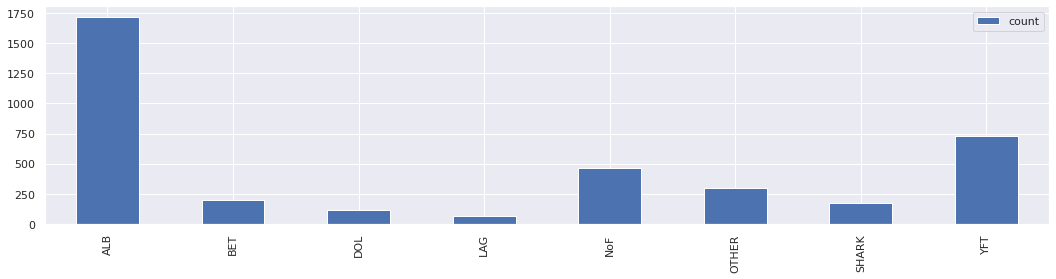

In [9]:
obj_classes = [ "ALB", "BET", "DOL", "LAG", "NoF", "OTHER", "SHARK", "YFT" ]

obj_count = {}
for o in obj_classes:  
    obj_count[o] = {"count":len(os.listdir(KAGGLE_FISHERIES_TRAIN_IMG+"/"+o))}
df = pd.DataFrame.from_dict(obj_count, orient='index')   
df.plot.bar(figsize=(18,4),grid=True);

In [10]:
df

,count
ALB,1719
BET,200
DOL,117
LAG,67
NoF,465
OTHER,299
SHARK,176
YFT,734


## Organizar para YOLOv4

Crear estructura de directorios.

In [11]:
YOLOV4_DATASET_BASE_PATH=WORKSPACE_DATA_PATH + "/datasets/kaggle-fisheries-yolo/"
YOLOV4_IMG_DIR="data"
YOLOV4_BACKUP_DIR="backup"
if os.path.exists(YOLOV4_DATASET_BASE_PATH):
    shutil.rmtree(YOLOV4_DATASET_BASE_PATH)

# crear estructura de directorios
os.mkdir(YOLOV4_DATASET_BASE_PATH)
os.mkdir(YOLOV4_DATASET_BASE_PATH+YOLOV4_IMG_DIR)
os.mkdir(YOLOV4_DATASET_BASE_PATH+YOLOV4_BACKUP_DIR)

In [12]:
shutil.copy("fisheries.data",YOLOV4_DATASET_BASE_PATH)

'../..//data//datasets/kaggle-fisheries-yolo/fisheries.data'

In [13]:
shutil.copy("yolo-fisheries.cfg",YOLOV4_DATASET_BASE_PATH)

'../..//data//datasets/kaggle-fisheries-yolo/yolo-fisheries.cfg'

Archivo object.names

In [14]:
with open(YOLOV4_DATASET_BASE_PATH+"/obj.names","wt") as f:
    for c in list(class_labels.keys())[:-1]:
        f.write(c+ os.linesep)
    # Para evitar el último \n
    f.write(list(class_labels.keys())[-1])

In [15]:
!ls {KAGGLE_FISHERIES_DATASET_YOLO}

backup	data  fisheries.data  obj.names  yolo-fisheries.cfg


Preparación de BBs para formato YOLOv4.

In [16]:
def obtain_yolov4_bbs(img_filename,class_idx,entry,preview=False):
    """Obtiene las bounding boxes de una entrada de JSON y genera un string
       en formato YOLOv4 (Darknet) y devuelve una lista con las BBs.
    """
    yolo_str = ""  
    pil_img = PIL.Image.open(img_filename)   
    img = np.array(pil_img)
    img_w = img.shape[1]
    img_h = img.shape[0]
    boxes = []
    for bb in entry['annotations']:
        x = int(bb['x'])
        y = int(bb['y'])
        w = int(bb['width'])
        h = int(bb['height'])
        xc = (2*x+w)/2
        yc = (2*y+h)/2

        # Yolo (norm)
        xc_norm = xc / img_w
        yc_norm = yc / img_h
        w_norm = w / img_w
        h_norm = h / img_h

        boxes.append({
            "class": class_idx,
            "xc": xc_norm,
            "yc": yc_norm,
            "w": w_norm,
            "h": h_norm
        })

        if preview:        
            img = cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (0,255,0), 2)
            img = cv2.circle(img, (int(xc), int(yc)), 10,(0,255,0))

        yolo_str+= "%d %f %f %f %f" % (class_idx, xc_norm,yc_norm,w_norm,h_norm) + os.linesep

    if preview:
        fig,axes = plt.subplots(figsize=(16,8))
        axes.imshow(img, interpolation='bicubic', aspect='auto');
        axes.grid(False)
    return yolo_str,boxes

In [17]:
!ls {KAGGLE_FISHERIES_TRAIN_IMG}

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


##### Archivos de anotación de BBs de imagenes

Cada imagen debe ser acompañada por un .txt del mismo nombre con esta estructura:

Ejemplo:

~~~
<object-class> <x_center> <y_center> <width> <height>
~~~

In [18]:
img_boxes = {}

KAGGLE_FISHERIES_DATASET_YOLO_IMAGES = YOLOV4_DATASET_BASE_PATH+YOLOV4_IMG_DIR

for k,v in class_labels.items():
    print(v)
    class_idx = v['class_idx']
    bb_filename = v['bb_filename']  
    base_img_path = v['train_img']
    with open(bb_filename) as f:
        labels = json.load(f)
  
    for img_entry in labels:        
        img_filename = "%s/%s" % (base_img_path,os.path.basename(img_entry['filename']))
        txt_filename = os.path.splitext(os.path.basename(img_filename))[0]+".txt"    
        try:      
            shutil.copy2(img_filename, KAGGLE_FISHERIES_DATASET_YOLO_IMAGES)
            yolo_bb_str,boxes = obtain_yolov4_bbs(img_filename,class_idx,img_entry,preview=False)

            img_name = os.path.basename(img_entry['filename'])
            if img_name not in img_boxes:
                img_boxes[img_name] = []
            img_boxes[img_name].append(boxes)

            with open("%s/%s" % (KAGGLE_FISHERIES_DATASET_YOLO_LABELS,txt_filename),"w") as fp:
                fp.write(yolo_bb_str)
        except FileNotFoundError:
            print("Warning. %s not found" % img_filename)

{'class_idx': 0, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/alb_labels.json', 'train_img': '../..//data//datasets/kaggle-fisheries//train//ALB'}
{'class_idx': 1, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/bet_labels.json', 'train_img': '../..//data//datasets/kaggle-fisheries//train//BET'}
{'class_idx': 2, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/dol_labels.json', 'train_img': '../..//data//datasets/kaggle-fisheries//train//DOL'}
{'class_idx': 3, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/lag_labels.json', 'train_img': '../..//data//datasets/kaggle-fisheries//train//LAG'}
{'class_idx': 4, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/shark_labels.json', 'train_img': '../..//data//datasets/kaggle-fisheries//train//SHARK'}
{'class_idx': 5, 'bb_filename': '../..//data//datasets/kaggle-fisheries//kaggle-ncfm/yft_labels.json', 'train_img': '../..//data//datasets/kaggle-

##### Archivos train.txt y test.txt:

~~~
data/<image_path>
~~~

In [19]:
filenames = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(YOLOV4_DATASET_BASE_PATH+YOLOV4_IMG_DIR+"/*.txt")]

In [20]:
TRAIN_TEST_SPLIT = 0.3
n_samples = len(filenames)
img_dst_path = "./data/" # nombre de la carpeta en docker

i0=int(TRAIN_TEST_SPLIT*n_samples)
indexes = np.random.permutation(n_samples)
train,test = indexes[:i0],indexes[i0:]

with open(YOLOV4_DATASET_BASE_PATH+"/train.txt","w") as fp:
    for i in train:
        print(img_dst_path+filenames[i]+".jpg",file=fp)

with open(YOLOV4_DATASET_BASE_PATH+"/test.txt","w") as fp:
    for i in test:
        print(img_dst_path+filenames[i]+".jpg",file=fp)    

In [21]:
!ls {YOLOV4_DATASET_BASE_PATH}

backup	fisheries.data	test.txt   yolo-fisheries.cfg
data	obj.names	train.txt
